In [1]:
import numpy as np
import bayes3d as b
from tqdm import tqdm
import jax
import jax.numpy as jnp
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
import matplotlib.pyplot as plt
import os

import jaxopt
from jaxopt import OptaxSolver
import optax

In [2]:
# more objects, make grid 5

In [3]:
def projection(x=0.1, n=1.0, f=50.0):
    return jnp.array([[n/x,    0,            0,              0],
                      [  0,  n/x,            0,              0],
                      [  0,    0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                      [  0,    0,           -1,              0]])

def translate(x, y, z):
    return jnp.array([[1.0, 0, 0, x],
                      [0, 1, 0, y],
                      [0, 0, 1, z],
                      [0, 0, 0, 1]])

def xfm_points(points, matrix):
    points = jnp.concatenate([points, jnp.ones((*points.shape[:-1],1))], axis=-1)
    return jnp.matmul(points, matrix.T)

def random_angles(key):
    theta_key, phi_key, omega_key = jax.random.split(key, 3)
    theta = jax.random.choice(theta_key, jnp.linspace(0, 2*jnp.pi, 100))
    phi   = jax.random.choice(phi_key, jnp.linspace(0, 2*jnp.pi, 100))
    omega = jax.random.choice(omega_key, jnp.linspace(0, 2*jnp.pi, 100))
    return theta, phi, omega

def random_translation(key, bbox_len):
    x_key, y_key, z_key = jax.random.split(key, 3)
    translation = jnp.array([0.0, 0.0, -3.2])
    x_del = jax.random.choice(x_key, jnp.linspace(-bbox_len, bbox_len, 100))
    y_del = jax.random.choice(y_key, jnp.linspace(-bbox_len, bbox_len, 100))
    z_del = jax.random.choice(z_key, jnp.linspace(-bbox_len, bbox_len, 100))
    return translation + jnp.array([x_del, y_del, z_del])

def spherical_to_cartesian(theta, phi):
    return jnp.array([jnp.sin(phi)*jnp.cos(theta),
                      jnp.sin(phi)*jnp.sin(theta),
                      jnp.cos(phi)])


def get_pos_and_pos_idx(idx):
    model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    m = b.utils.load_mesh(mesh_path)
    m = b.utils.scale_mesh(m, 1.0/100.0)

    pos = jnp.array(m.vertices.astype(np.float32))
    pos_idx = jnp.array(m.faces.astype(np.int32))
    return (pos, pos_idx)

In [4]:
idx = 10

mvp = jnp.matmul(projection(x=0.4), translate(0, 0, 0.0))
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=200.0, fy=200.0,
    cx=100.0, cy=100.0,
    near=0.01, far=5.5
)
jax_renderer = JaxRenderer(intrinsics)

pos, pos_idx = get_pos_and_pos_idx(idx)

pos_list = []
for ind in range(10,15):
    pos_list.append(get_pos_and_pos_idx(ind))


In [5]:
# theta, phi = spherical coordinates
# omega = rotation angle
def render_img(pos, pos_idx, translation, theta, phi, omega):
    axis = spherical_to_cartesian(theta, phi)
    pose = b.transform_from_rot_and_pos(b.rotation_from_axis_angle(axis, omega), translation)

    final_mtx_proj = mvp @ pose

    posw = jnp.concatenate([pos, jnp.ones((*pos.shape[:-1],1))], axis=-1)
    pos_clip_ja = xfm_points(pos, final_mtx_proj)

    rast_out, rast_out_db = jax_renderer.rasterize(pos_clip_ja[None,...], pos_idx, jnp.array([intrinsics.height, intrinsics.width]))
    gb_pos,_ = jax_renderer.interpolate(posw[None,...], rast_out, pos_idx, rast_out_db, jnp.array([0,1,2,3]))
    #mask = rast_out[..., -1] > 0
    shape_keep = gb_pos.shape
    gb_pos = gb_pos.reshape(shape_keep[0], -1, shape_keep[-1])
    gb_pos = gb_pos[..., :3]
    depth = xfm_points(gb_pos, pose)
    depth = depth.reshape(shape_keep)[..., 2] * -1
    return depth

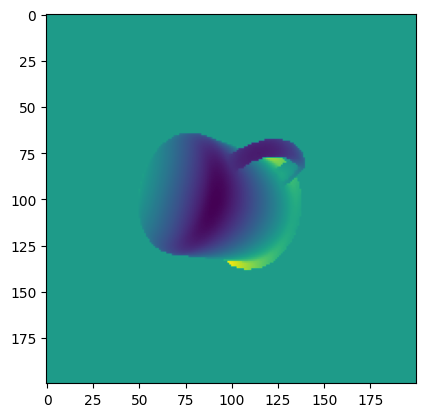

In [21]:
key = jax.random.PRNGKey(2)
key = jax.random.split(key, 2)
translation = jnp.array([0.0, 0.0, -3.2])
# hardcode to mug

gt_ind = len(pos_list) - 1
gt_img = render_img(pos_list[gt_ind][0], pos_list[gt_ind][1], random_translation(key[0], 0.05), *random_angles(key[1]))
fig, ax = plt.subplots(1)
ax.imshow(gt_img[0,...])

In [22]:
grid_size = 5
thetas = jnp.linspace(0, 2*jnp.pi, grid_size)
phis   = jnp.linspace(0, jnp.pi/2, grid_size)
omegas = jnp.linspace(0, 2*jnp.pi, grid_size)

In [23]:
base_translation = jnp.array([0.0, 0.0, -3.2])
bbox_len = 0.05
xs = jnp.linspace(-bbox_len, bbox_len, 1) + base_translation[0]
ys = jnp.linspace(-bbox_len, bbox_len, 1) + base_translation[1]
zs = jnp.linspace(-bbox_len, bbox_len, 1) + base_translation[2]
translation_meshgrid = jnp.meshgrid(thetas, phis, omegas, xs,ys,zs, indexing='ij')
translation_meshgrid = jnp.array(translation_meshgrid).reshape(6,-1)
param_list = translation_meshgrid.T

In [24]:
def loss_fn_mod(params, gt_img, pos, pos_ind):
    theta, phi, omega, t_x,t_y,t_z = params
    # translation = jnp.array([0.0, 0.0, -3.2])
    # pos, pos_ind = pos_list[obj_idx]
    img = render_img(pos, pos_ind, jnp.array([t_x, t_y, t_z]), theta, phi, omega)
    return jnp.mean(jnp.abs(gt_img - img))

In [25]:
final_losses = []
loss_trajs = []
final_params = []
obj_ids = []

for p_ind, init_params in enumerate(param_list):
    # optimizer = torch.optim.Adam([pos], betas=(0.9, 0.999), lr=)
    # optimizer2 = torch.optim.Adam([quat], betas=(0.9, 0.999), lr=2e-3)
    print(p_ind)
    for obj_id in range(len(pos_list)):
        p, p_ind = pos_list[obj_id]

        lr1 = 1e-3
        opt1 = optax.adam(lr1)
        solver = OptaxSolver(opt=opt1,fun=loss_fn_mod,maxiter=10000)
        state = solver.init_state(init_params, gt_img=gt_img, pos=p, pos_ind=p_ind)
        params = init_params
        losses = []
        for _ in range(1000):
            params, state = solver.update(params, state, gt_img=gt_img, pos=p, pos_ind=p_ind)
            losses.append(state.value.tolist())
        loss_trajs.append(losses)
        final_losses.append(losses[-1])
        final_params.append(params)
        obj_ids.append(obj_id)

0
1
2
3
4
5
6
7


In [26]:
print(final_params)
print(final_losses)
loss_trajs = jnp.array(loss_trajs)

min_run = np.argmin(final_losses)
params = final_params[min_run]
losses = loss_trajs[min_run]
obj_ind = obj_ids[min_run]
init_params = param_list[min_run]

[Array([ 1.7825821e-03, -7.8463368e-03, -7.0416629e-03, -4.1037854e-02,
       -4.6854369e-02, -3.2400033e+00], dtype=float32), Array([ 0.00392509,  0.00809874,  0.01005573, -0.06004898, -0.06003192,
       -3.2400017 ], dtype=float32), Array([ 1.7766098e-03, -7.8366911e-03,  6.2761450e+00, -4.1036136e-02,
       -4.6852466e-02, -3.2400033e+00], dtype=float32), Array([ 4.0374994e-03,  8.2022082e-03,  6.2932410e+00, -6.0049001e-02,
       -6.0031854e-02, -3.2400017e+00], dtype=float32), Array([ 0.00820191,  1.5773323 ,  0.00678031, -0.04044755, -0.03994298,
       -3.2400036 ], dtype=float32), Array([ 0.00815723,  1.5627254 ,  0.01003531, -0.06010195, -0.06003098,
       -3.2400017 ], dtype=float32), Array([ 0.00820943,  1.5773346 ,  6.2899656 , -0.04044756, -0.03994298,
       -3.2400036 ], dtype=float32), Array([ 0.00819745,  1.5626565 ,  6.2932215 , -0.06010213, -0.0600311 ,
       -3.2400017 ], dtype=float32), Array([ 6.284968  , -0.00784634, -0.00704166, -0.04103785, -0.04685437,
 

object: 1
translation: [-0.06010213 -0.0600311  -3.2400017 ]
rotation: [Array(0.00819745, dtype=float32), Array(1.5626565, dtype=float32), Array(6.2932215, dtype=float32)]


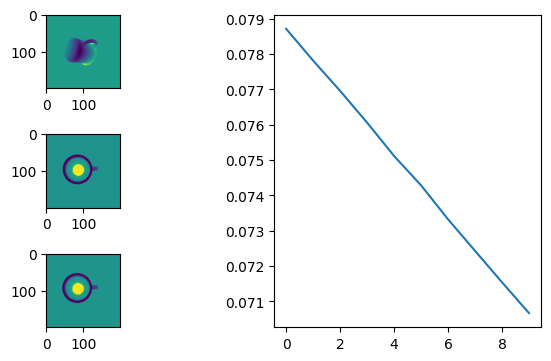

In [34]:
theta = params[0]
phi = params[1]
omega = params[2]
trans = jnp.array(params[3:])


init_theta = init_params[0]
init_phi = init_params[1]
init_omega = init_params[2]
init_trans = jnp.array(init_params[3:])

pos_optim, pos_ind_optim = pos_list[obj_ind]

fig, axd = plt.subplot_mosaic([['gt',   'losses'],
                               ['init', 'losses'],
                               ['fin',  'losses']],
                              figsize=(6.0, 3.5), layout="constrained")
axd['gt'].imshow(gt_img[0,...])
axd['init'].imshow(render_img(pos_optim, pos_ind_optim, init_trans, init_theta, init_phi, init_omega)[0,...])
axd['fin'].imshow(render_img(pos_optim, pos_ind_optim, trans, theta, phi, omega)[0,...])
axd['losses'].plot(losses)

plt.savefig('final_optim_plt.png')
print('object: ' + str(obj_ind))
print('translation: ' + str(trans))
print('rotation: '+ str([theta, phi, omega]))